# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

## Практическое задание

1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете cifar10
2. оценить рост точности при увеличении ширины сети (больше фильтров)
3. оценить рост точности при увеличении глубины сети (больше слоев)
4. *сравнить с точностью полносвязной сети для этой выборки

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

Скачаем датасет:

In [ ]:
# установка параметров нейросети
batch_size = 1024
num_classes = 10
# epochs = 1
# data_augmentation = False
# num_predictions = 20
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# model_name = 'keras_cifar10_trained_model.h5'

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170508288/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [ ]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

Создадим бейзлайн для дальнейших экспериментов.

Конфигурация представленной сети была подобрана вручную, перебором различных параметров. Основные нюансы сети:


*   Сеть имеет 3 сверточных слоя. Оптимальными оказались ядра 5, 4, 3. При первом ядре, большем 5, результат оказывается хуже.
*   2 плотных слоя по 512 нейронов - оптимальная конфигурация для данного примера
*   Слои Dropout помогли существенно сократить переобучение и увеличить метрику на тесте. 25% верооятности отключения нейрона - оптимальный параметр.
*   Аугументацию не использовал - долго. Но она помогала сократить переобучение





In [ ]:
data_augmentation = False

# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (4, 4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=30,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=30,
                        validation_data=(x_test, y_test),
                        workers=-1)

# сохранение модели и весов
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Не используется data augmentation
Epoch 1/30
49/49 [==============================] - 4s 66ms/step - loss: 2.0316 - accuracy: 0.2509 - val_loss: 1.7768 - val_accuracy: 0.3855
Epoch 2/30
49/49 [==============================] - 3s 58ms/step - loss: 1.6478 - accuracy: 0.3997 - val_loss: 1.5555 - val_accuracy: 0.4459
Epoch 3/30
49/49 [==============================] - 3s 59ms/step - loss: 1.4561 - accuracy: 0.4707 - val_loss: 1.3381 - val_accuracy: 0.5224
Epoch 4/30
49/49 [==============================] - 3s 59ms/step - loss: 1.3510 - accuracy: 0.5128 - val_loss: 1.2608 - val_accuracy: 0.5613
Epoch 5/30
49/49 [==============================] - 3s 58ms/step - loss: 1.2435 - accuracy: 0.5535 - val_loss: 1.1939 - val_accuracy: 0.5825
Epoch 6/30
49/49 [==============================] - 3s 59ms/step - loss: 1.1667 - accuracy: 0.5813 - val_loss: 1.0795 - val_accuracy: 0.6222
Epoch 7/30
49/49 [==============================] - 3s 59ms/step - loss: 1.0939 - accuracy: 0.6107 - val_loss: 1.0314 - 

Поэкспериментируем с шириной сети. К первому сверточному слою будем добавлять по 10 слоев, ко второму - по 20 и т.д.

313/313 [==============================] - 1s 3ms/step - loss: 0.6876 - accuracy: 0.7710
Test loss: 0.6875891089439392
Test accuracy: 0.7710000276565552
313/313 [==============================] - 1s 4ms/step - loss: 0.6887 - accuracy: 0.7780
Test loss: 0.6886950731277466
Test accuracy: 0.777999997138977
313/313 [==============================] - 1s 3ms/step - loss: 0.7242 - accuracy: 0.7838
Test loss: 0.7242122292518616
Test accuracy: 0.7838000059127808
313/313 [==============================] - 1s 4ms/step - loss: 0.7756 - accuracy: 0.7818
Test loss: 0.7755724787712097
Test accuracy: 0.7817999720573425


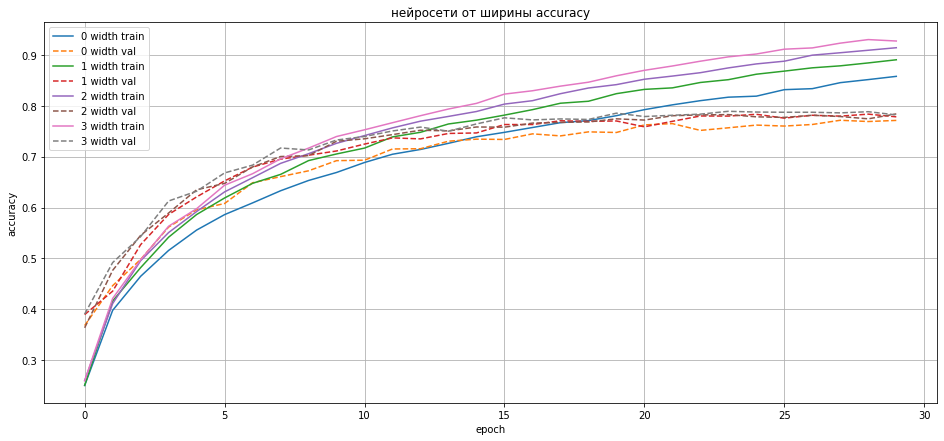

In [ ]:
plt.figure(figsize=(16,7))
# число рабочих эпох
epochs = 30
# вектор для выводв результатов
epoch = np.arange(epochs)  

for i in range(4):
  # конфигурирование слоев нейросети
  model = Sequential()

  # слои нейросети отвественные за свертку и max-pooling
  model.add(Conv2D(32 + i * 10, (5, 5), activation='relu', padding='same', input_shape=x_train.shape[1:]))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout( 0.25))

  model.add(Conv2D(64 + i * 20, (4, 4), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout( 0.25))

  model.add(Conv2D(128 + i * 40, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout( 0.25))

  # полносвязные слои нейронной сети
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(num_classes, activation='softmax'))

  # компиляция модели
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  hh = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=30,
            validation_data=(x_test, y_test),
            shuffle=True,
            verbose = 0)
  
  plt.plot(epoch,hh.history['accuracy'],'-',label = f'{i} width' +' train')
  plt.plot(epoch,hh.history['val_accuracy'],'--',label = f'{i} width' + ' val')

  # проверка работы обученной модели
  scores = model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])

plt.legend()
plt.grid('On')

plt.title('нейросети от ширины accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Видно, что самая широкая сеть довольно хорошо ведет себя на тесте (серая пунктирная линия). Под конец она начинает переобучаться, но на 25 эпохах показывает лучший результат среди всех.

Теперь попробуем увеличить глубину сети. Будем добавлять к первому сверточному слою еще такие же до первого пуллинга.

313/313 [==============================] - 1s 4ms/step - loss: 0.7683 - accuracy: 0.7871
Test loss: 0.7682600617408752
Test accuracy: 0.7871000170707703
313/313 [==============================] - 2s 5ms/step - loss: 0.7419 - accuracy: 0.7962
Test loss: 0.7419078350067139
Test accuracy: 0.7961999773979187
313/313 [==============================] - 2s 6ms/step - loss: 0.7981 - accuracy: 0.7853
Test loss: 0.7981006503105164
Test accuracy: 0.7853000164031982


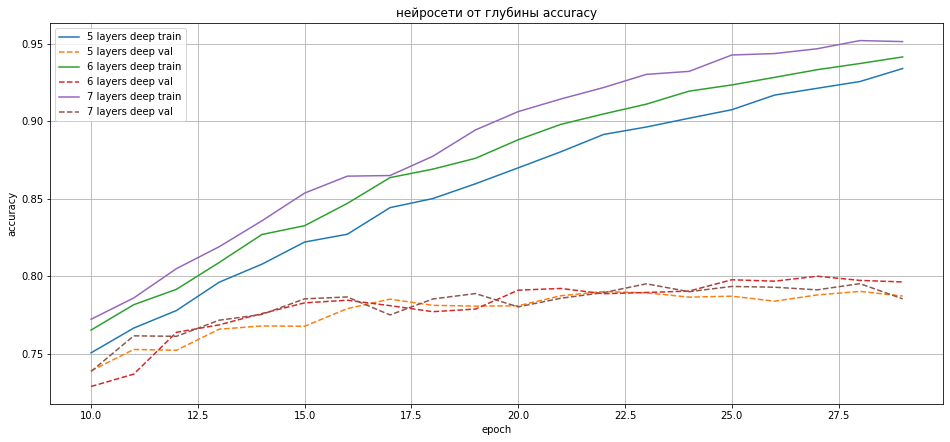

In [ ]:
plt.figure(figsize=(16,7))
# число рабочих эпох
epochs = 30
# вектор для выводв результатов
epoch = np.arange(epochs)  

for i in range(3):
  # конфигурирование слоев нейросети
  model = Sequential()

  # слои нейросети отвественные за свертку и max-pooling
  model.add(Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=x_train.shape[1:]))
  for j in range(i):
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout( 0.25))

  model.add(Conv2D(128, (4, 4), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout( 0.25))

  model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout( 0.25))

  # полносвязные слои нейронной сети
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(num_classes, activation='softmax'))

  # компиляция модели
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  hh = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=30,
            validation_data=(x_test, y_test),
            shuffle=True,
            verbose = 0)
  
  plt.plot(epoch[10:],hh.history['accuracy'][10:],'-',label = f'{i + 5} layers deep' +' train')
  plt.plot(epoch[10:],hh.history['val_accuracy'][10:],'--',label = f'{i + 5} layers deep' + ' val')

  # проверка работы обученной модели
  scores = model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])

plt.legend()
plt.grid('On')

plt.title('нейросети от глубины accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Итак, лучшей оказалась сеть с двумя сверточными слоями до первого пуллинга с одинаковым ядром 5.

Обучим конечную модель:

In [ ]:
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(128, (4, 4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hh = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=26,
          validation_data=(x_test, y_test),
          shuffle=True,
          verbose = 1)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/26
49/49 [==============================] - 12s 233ms/step - loss: 2.0263 - accuracy: 0.2373 - val_loss: 1.7550 - val_accuracy: 0.3632
Epoch 2/26
49/49 [==============================] - 11s 230ms/step - loss: 1.6259 - accuracy: 0.3953 - val_loss: 1.4884 - val_accuracy: 0.4523
Epoch 3/26
49/49 [==============================] - 12s 235ms/step - loss: 1.4094 - accuracy: 0.4834 - val_loss: 1.2961 - val_accuracy: 0.5258
Epoch 4/26
49/49 [==============================] - 12s 236ms/step - loss: 1.2641 - accuracy: 0.5433 - val_loss: 1.1584 - val_accuracy: 0.5854
Epoch 5/26
49/49 [==============================] - 11s 233ms/step - loss: 1.1396 - accuracy: 0.5898 - val_loss: 1.0621 - val_accuracy: 0.6214
Epoch 6/26
49/49 [==============================] - 11s 231ms/step - loss: 1.0231 - accuracy: 0.6359 - val_loss: 0.9566 - val_accuracy: 0.6616
Epoch 7/26
49/49 [==============================] - 11s 229ms/step - loss: 0.9321 - accuracy: 0.6695 - val_loss: 0.8854 - val_accuracy: 0.6883

Сохраним предсказания нейросети:

In [ ]:
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Построим матрицу ошибок по классам:

Confusion matrix, without normalization


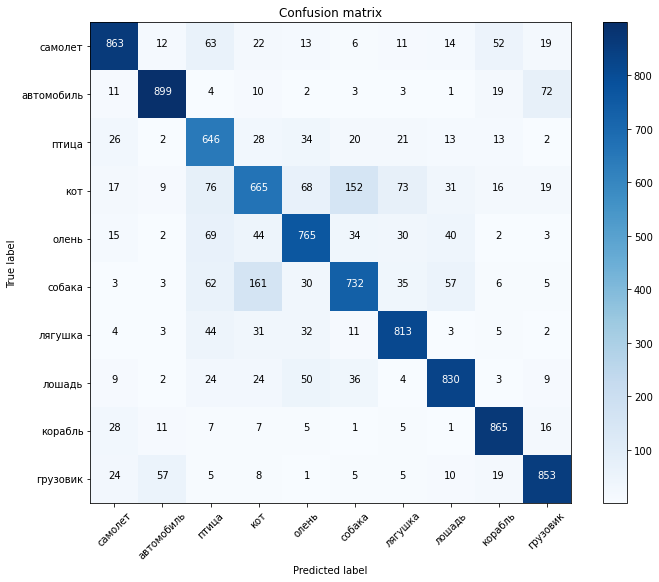

In [ ]:
cnf_matrix = confusion_matrix(y_pred_class, y_true)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')

Хуже всего сеть предсказывает кота - она часто его путает с собакой, и птицу - ее она путает вообще со всем подряд. Как вариант, можно обучать нейросети по одной на каждый класс "один против всех".

Сохраним веса модели.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_weights('/content/drive/My Drive/GeekBrains/NeuralNetworkIntro/hw4_model.h5')

Теперь попробуем для этой задачи обучить полносвязную сеть из двух слоев:

In [ ]:
model = Sequential([Flatten(input_shape=x_train.shape[1:]),
                      Dense(16384, activation='relu'),
                     Dense(16384, activation='relu'),
                      Dense(10, activation='softmax'),
                      ])

model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
      )

hh = model.fit(
            x_train,
            y_train,
            epochs=30,
            batch_size=batch_size, 
            validation_data=(x_test, y_test),
            shuffle=True,
            verbose = 1)

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/30
49/49 [==============================] - 47s 957ms/step - loss: 8.7672 - accuracy: 0.2472 - val_loss: 1.8084 - val_accuracy: 0.3565
Epoch 2/30
49/49 [==============================] - 46s 948ms/step - loss: 1.7351 - accuracy: 0.3776 - val_loss: 1.6781 - val_accuracy: 0.4031
Epoch 3/30
49/49 [==============================] - 46s 949ms/step - loss: 1.6331 - accuracy: 0.4173 - val_loss: 1.5998 - val_accuracy: 0.4256
Epoch 4/30
49/49 [==============================] - 46s 947ms/step - loss: 1.5849 - accuracy: 0.4345 - val_loss: 1.5765 - val_accuracy: 0.4417
Epoch 5/30
49/49 [==============================] - 46s 945ms/step - loss: 1.5294 - accuracy: 0.4552 - val_loss: 1.5297 - val_accuracy: 0.4508
Epoch 6/30
49/49 [==============================] - 46s 946ms/step - loss: 1.4828 - accuracy: 0.4713 - val_loss: 1.4912 - val_accuracy: 0.4693
Epoch 7/30
49/49 [==============================] - 46s 946ms/step - loss: 1.4529 - accuracy: 0.4830 - val_loss: 1.4931 - val_accuracy: 0.4645

**Вывод:**

Мы получили очень широкую полносвязную сеть, которая довольно долго обучалась, а при этом полученная метрика на тесте - всего 53%. Соответственно, для задач классификации сложных изображений CNN пподходит существенно лучше.